<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="https://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/llibre-estil/logo-UOC-masterbrand-vertical.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PEC1</p>
<p style="margin: 0; text-align:right;">2023-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 1: Redes neuronales artificiales y convolucionales con Keras

A lo largo de esta práctica vamos a implementar varios modelos de redes neuronales para clasificar las imágenes de una base de datos de animales. En concreto:
- Se realizará un estudio de la base de datos proporcionada.
- Se implementará una red completamente conectada para establecer un modelo de referencia o <i>baseline</i>.
- Se implementará una red convolucional.
- Se implementará una red convolucional profunda a partir de un modelo conocido (InceptionV3) pre-entrenado en Imagenet utilizando <i>transfer-learning</i>.
- Se analizarán los resultados del mejor modelo obtenido.

<u>Consideraciones generales</u>:

- La solución planteada no puede utilizar métodos, funciones o parámetros declarados **_deprecated_** en futuras versiones.
- Esta PEC debe realizarse de forma **estrictamente individual**. Cualquier indicio de copia será penalizado con un suspenso (D) para todas las partes implicadas y la posible evaluación negativa de la asignatura de forma íntegra.
- Es necesario que el estudiante indique **todas las fuentes** que ha utilizado para la realización de la PEC. De no ser así, se considerará que el estudiante ha cometido plagio, siendo penalizado con un suspenso (D) y la posible evaluación negativa de la asignatura de forma íntegra.

<u>Formato de la entrega</u>:

- Algunos ejercicios pueden suponer varios minutos de ejecución, por lo que la entrega debe hacerse en **formato notebook** y en **formato html**, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a HTML en Jupyter Notebook desde el menú File $\to$ Download as $\to$ HTML.
- Existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de la actividad. Para cambiar el tipo de celda a este tipo, en el menú: Cell $\to$ Cell Type $\to$ Markdown.

## 0. Contexto y carga de librerías
A lo largo de esta práctica vamos a implementar varios modelos de redes neuronales para clasificar las imágenes de la base de datos [Animals-10](https://www.kaggle.com/datasets/alessiocorrado99/animals10).

La base de datos Animals-10 Contiene alrededor de 28.000 imágenes de animales de calidad media pertenecientes a 10 categorías, cada una en una carpeta distinta. El recuento de imágenes para cada categoría varía entre 2.000 y 5.000 imágenes.

Concretamente en esta PEC utilizaremos una versión de esta base de datos que tiene separados los conjuntos de entrenamiento y test.

**Nota: Se recomienda realizar la práctica en el entorno que ofrece la plataforma Kaggle, ya que ofrece un entorno gratuito con 30 horas semanales de uso de GPU.**

A lo largo de toda la práctica, para la creación de las distintas redes, iremos alternando el uso del modelo [Sequential](https://keras.io/guides/sequential_model/) y el modelo [Functional](https://keras.io/guides/functional_api/) de Keras a través de las clases [Sequential](https://keras.io/api/models/sequential/) y [Model](https://keras.io/api/models/model/) respectivamente.

Se aconseja la lectura detallada de la documentación de ambos modelos para llevar a cabo la realización de la práctica.

Empezamos instalando y cargando las librerías mas relevantes:

In [ ]:
# Instalamos la última versión de Tensorflow (con CUDA)
%pip install tensorflow[and-cuda]

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Importamos TensorFlow
import tensorflow as tf
print("TF version   : ", tf.__version__)

# Necesitaremos GPU
print("GPU available: ", tf.config.list_physical_devices('GPU'))

# keras version is 3.0.5
import keras
print("Keras version   : ", keras.__version__)

TF version   :  2.15.0
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Keras version   :  3.0.5


In [ ]:
# Importamos los elementos de keras que utilizaremos con mayor frecuencia
from keras.utils import image_dataset_from_directory
from keras.layers import (
    GlobalAveragePooling2D, Flatten, Input,
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization,
    MaxPooling2D, UpSampling2D, Rescaling, Resizing,
    RandomFlip, RandomRotation, RandomZoom, RandomContrast)
from keras.callbacks import (EarlyStopping, ReduceLROnPlateau)
from keras.optimizers import (Adam, RMSprop)
from keras import Sequential, Model

In [ ]:
# Importamos el resto de librerías que necesitaremos para la PEC
import cv2
from PIL import Image
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.metrics import classification_report, confusion_matrix
import itertools

## 1. Descarga, análisis y pre-procesado de los datos (1,5 puntos)

En este apartado exploraremos la base de datos y prepararemos la carga de las imágenes para los modelos de los siguientes apartados.

Para crear nuestra base de datos tenemos que descargar el archivo de imágenes desde el siguiente [enlace](https://drive.google.com/file/d/1uPrn0kZb7selQl7pnHG7qwLm8hSOYZSd/view?usp=sharing) (es un archivo .zip que ocupa aproximadamente 600 MB).

**NOTA: para poder descargar el archivo de imágenes tenéis que iniciar sesión con el usuario y contraseña de la UOC.**

A partir de aquí:

- Si trabajamos en local simplemente tenemos que descomprimir el archivo descargado.

- Si trabajamos desde Kaggle. Debemos subir el Notebook del enunciado a la plataforma (para ello podéis seguir los 6 primeros pasos del siguiente [artículo](https://rajputankit22.medium.com/how-to-upload-my-own-notebook-to-kaggle-2b0dedbb5a6b)) y después, una vez subido el notebook, expandir la barra lateral desplegable de la derecha y en el menú 'Input'  clickar el botón 'Upload' y subir el archivo descargado previamente. Después hay que darle un nombre a la base de datos y cuando se cargue el fichero ya tendréis accesible la base de datos en la ruta <code>../input/</code>.

Una vez tenemos la base de datos accesible vamos a inspeccionarla.

En la carpeta <code>/images</code> (si trabajamos en local) o <code>/kaggle/input/nombre-base-de-datos/images/</code> (si trabajamos desde Kaggle) encontramos 2 carpetas:
- En la carpeta <code>/train/</code> se encuentra el total de las imágenes de entrenamiento separadas por clases (cada clase en una carpeta distinta), pero no se ha realizado una separación en conjunto de entrenamiento y validación.
- En la carpeta <code>/test/</code> se encuentra el total de las imágenes de test separadas por clases (cada clase en una carpeta distinta).

### 1.1. Análisis de los archivos de imágenes

En cualquier estudio que se quiera realizar es conveniente llevar a cabo un análisis de los datos disponibles con el fin de comprobar si la base de datos está balanceada y si los datos tienen un formato uniforme y adecuado para, en caso contrario, actuar en consecuencia.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio [0,5 pts.]:</strong> A partir de la estructura de carpetas, y para cada conjunto de datos (train y test) :
    <ul>
        <li>Extraer los nombres de las 10 clases en cada conjunto y comprobar que son iguales.</li>
        <li>Calcular el número total de imágenes del dataset.</li>
        <li>Extraer cuántas instancias tenemos en total para cada una de las clases y representarlas en un diagrama de barras.</li>
    </ul>
Contestad las siguientes preguntas:
    <ul>
        <li>¿Qué porcentaje de imágenes del total se ha dedicado para cada conjunto?</li>
        <li>En base al diagrama de barras de cada conjunto ¿Podemos afirmar que la distribución de instancias por clase es similar en ambos conjuntos? </li>
        <li>En cuanto al número de elementos por clase ¿Podemos afirmar que las clases están balanceadas?</li>
    </ul>
</div>

In [ ]:
# Extraer nombres de las clases
# Para el conjunto de datos de train
train_path_data = "/kaggle/input/animals-10-train-test/images/train"
print("=============================")
print("Train Categories")
print("=============================")
train_categories = os.listdir(train_path_data)
for category in train_categories:
    print(category)

Train Categories
spider
horse
butterfly
dog
chicken
elephant
sheep
cow
squirrel
cat


In [ ]:
# Extraer nombres de las clases
# Para el conjunto de datos de test
test_path_data = "/kaggle/input/animals-10-train-test/images/test"
print("=============================")
print("Test Categories")
print("=============================")
test_categories = os.listdir(test_path_data)
for category in test_categories:
    print(category)

Test Categories
spider
horse
butterfly
dog
chicken
elephant
sheep
cow
squirrel
cat


In [ ]:
if train_categories == test_categories:
    print('Las clases son las mismas en ambos conjuntos.')

Las clases son las mismas en ambos conjuntos.


In [ ]:
# Número de instancias por clase (conjunto de train)
train_list_images = glob.glob(os.path.join(train_path_data, "*/*.*"))
num_images_train = len(train_list_images)
print("El número total de instancias de entrenamiento es {}.\n".format(num_images_train))
print("=============================")
print("Category -- Number of Images")
print("=============================")
train_instances = []
for i, c in enumerate(train_categories):
    selected = [filename for filename in train_list_images if c in filename]
    print("{:<18} | {:<16}".format(c, len(selected)))
    train_instances.append(len(selected))

El número total de instancias de entrenamiento es 22253.

Category -- Number of Images
spider             | 4098            
horse              | 2230            
butterfly          | 1795            
dog                | 4136            
chicken            | 2633            
elephant           | 1229            
sheep              | 1547            
cow                | 1588            
squirrel           | 1583            
cat                | 1418            


In [ ]:
# Número de instancias por clase (conjunto de test)
test_list_images = glob.glob(os.path.join(test_path_data, "*/*.*"))
num_images_test = len(test_list_images)
print("El número total de instancias de test es {}.\n".format(num_images_test))
print("=============================")
print("Category -- Number of Images")
print("=============================")
test_instances = []
for i, c in enumerate(test_categories):
    selected = [filename for filename in test_list_images if c in filename]
    print("{:<18} | {:<16}".format(c, len(selected)))
    test_instances.append(len(selected))

El número total de instancias de test es 3926.

Category -- Number of Images
spider             | 723             
horse              | 393             
butterfly          | 317             
dog                | 730             
chicken            | 465             
elephant           | 217             
sheep              | 273             
cow                | 280             
squirrel           | 279             
cat                | 250             


In [ ]:
num_images = num_images_train + num_images_test
print("El número total de instancias es {}".format(num_images))
print("El número de instancias de entrenamiento {} supone un {:.0f} % del total.".format(num_images_train,num_images_train*100/num_images))
print("El número de instancias de test {} supone un {:.0f} % del total.".format(num_images_test,num_images_test*100/num_images))

El número total de instancias es 26179
El número de instancias de entrenamiento 22253 supone un 85 % del total.
El número de instancias de test 3926 supone un 15 % del total.


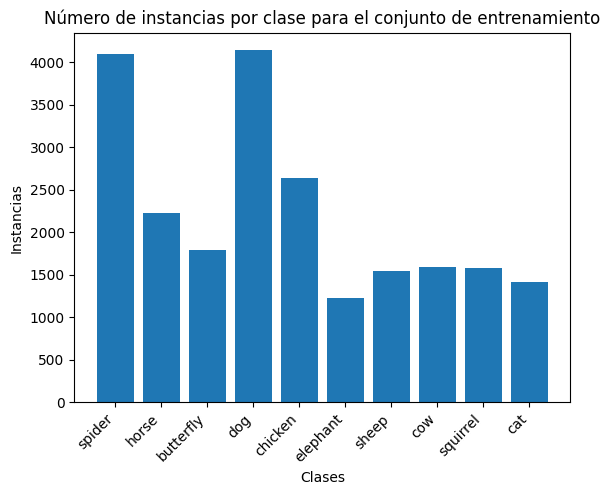

In [ ]:
# Representación del diagrama de barras (conjunto de train)

# Crear el gráfico de barras
plt.bar(train_categories, train_instances)
plt.xticks(rotation=45, ha='right')

# Añadir etiquetas y título
plt.xlabel('Clases')
plt.ylabel('Instancias')
plt.title('Número de instancias por clase para el conjunto de entrenamiento')

# Mostrar el gráfico
plt.show()

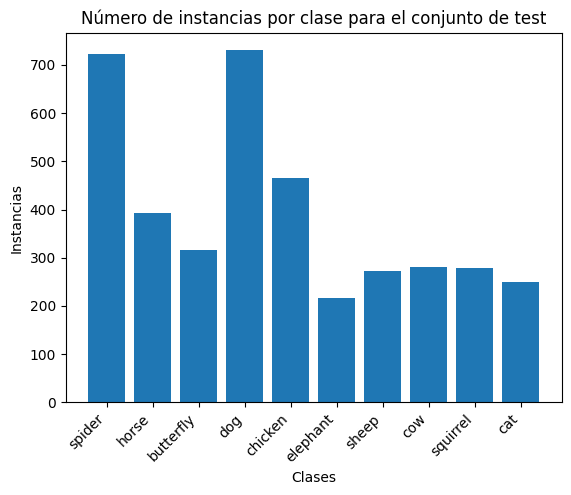

In [ ]:
# Representación del diagrama de barras (conjunto de test)

# Crear el gráfico de barras
plt.bar(test_categories, test_instances)
plt.xticks(rotation=45, ha='right')

# Añadir etiquetas y título
plt.xlabel('Clases')
plt.ylabel('Instancias')
plt.title('Número de instancias por clase para el conjunto de test')

# Mostrar el gráfico
plt.show()

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
    El número total de instancias es 26179. <br>
    El número de instancias de entrenamiento  es 22253 y supone un 85 % del total. <br>
    El número de instancias de test es 3926 y supone un 15 % del total. <br>
    Ambos conjuntos de datos presentan una distribución similar.<br>
    Como puede observarse en el diagrama de barras, el conjunto de datos no está del todo balanceado ya que hay dos clases ('spider' y 'dog') que tienen un número de instancias muy superior al resto.
</div>

### 1.2. Visualización de las imágenes.

Una vez hemos analizado la composición de la base de datos vamos a analizar ahora el formato de las imágenes. Para ello se pide:

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio[0,5 pts]:</strong> Visualiza a modo de ejemplo una imagen por cada categoría y responde a las siguientes preguntas:
<ul>
    <li>¿Tienen todas las imágenes el mismo tamaño?</li>
    <li>¿Qué rango dinámico (valores mínimo y máximo) tienen las imágenes?</li>
    <li>¿Son adecuados estos valores para el entrenamiento de una red convolucional?</li>
    <li>¿Qué acciones se deberían tomar al respecto?</li>
</ul>
</div>


Random visualization


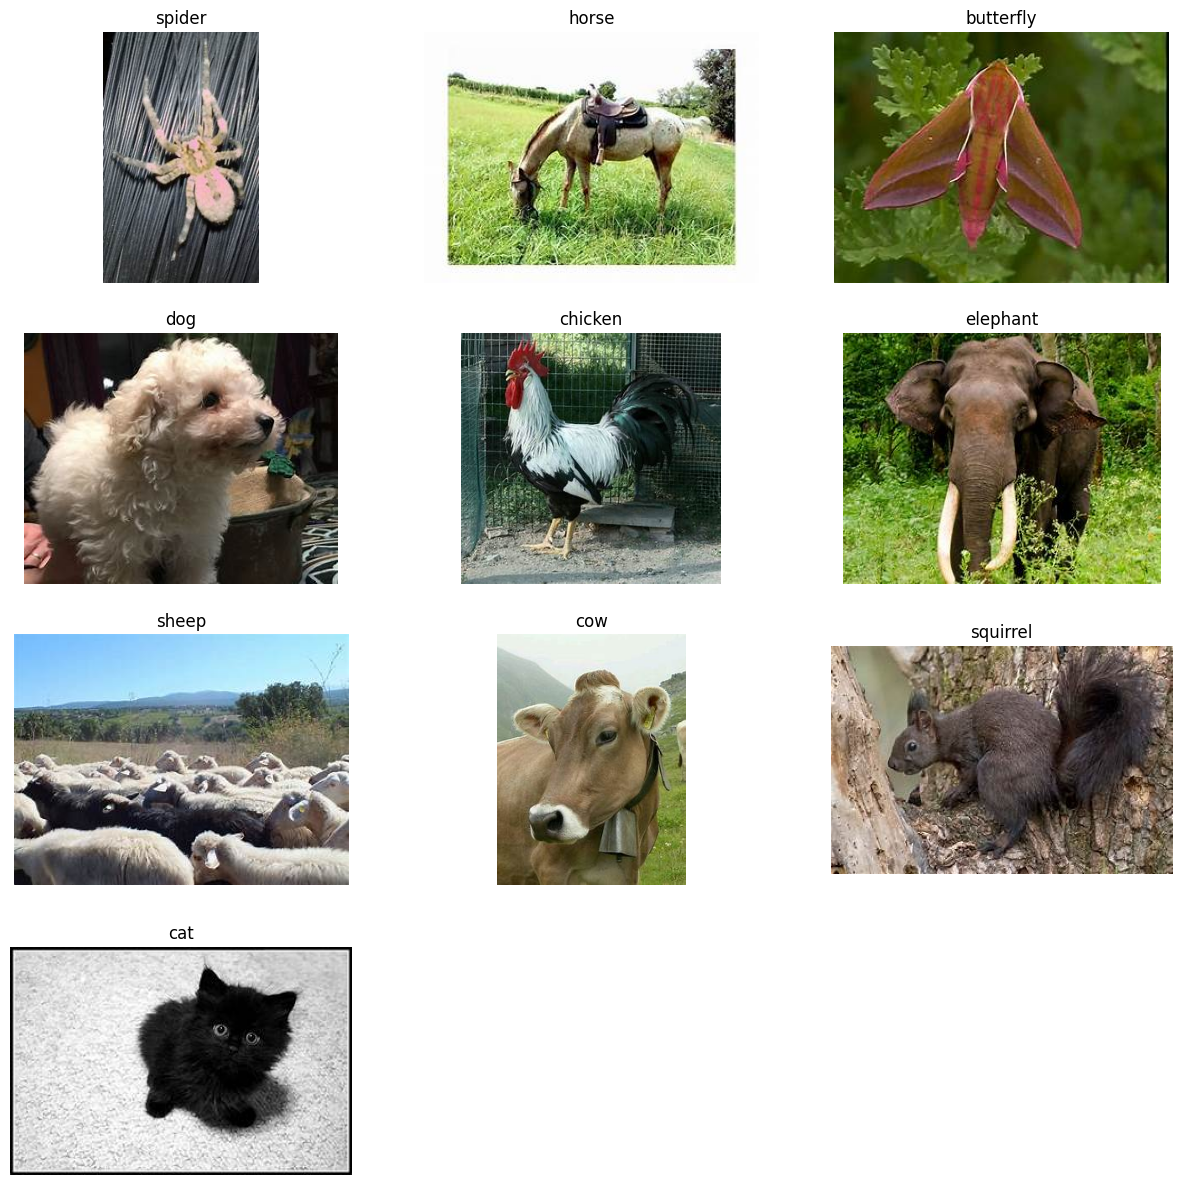

In [ ]:
# Visualización de las imágenes

plt.figure(figsize=(15,15))

for i, c in enumerate(train_categories):
    selected = [filename for filename in train_list_images if c in filename]
    np.random.shuffle(selected)
    img = Image.open(selected[0])
    plt.subplot(4,3, 1+i), plt.imshow(img)
    plt.title(c)
    plt.axis('off')


print()
print("=============================")
print("Random visualization")
print("=============================")
plt.show()

In [ ]:
# Cálculo del rango dinámico

path_data = "/kaggle/input/animals-10-train-test/images/"

min_width = float('inf')
min_height = float('inf')
min_val = float('inf')
max_width = 0
max_height = 0
max_val = 0

for root, dirs, files in os.walk(path_data):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):  # asegurarse de que solo se procesen archivos de imagen
            filepath = os.path.join(root, file)
            with Image.open(filepath) as img:
                width, height = img.size
                img_array = np.array(img)
                min_val = min(min_val, np.min(img_array))
                max_val = max(max_val, np.max(img_array))
                min_width = min(min_width, width)
                min_height = min(min_height, height)
                max_width = max(max_width, width)
                max_height = max(max_height, height)

print("Dimensiones mínimas: {}x{}".format(min_width, min_height))
print("Dimensiones máximas: {}x{}".format(max_width, max_height))
print("Rango dinámico: {} - {}".format(min_val, max_val))

Dimensiones mínimas: 60x57
Dimensiones máximas: 6720x6000
Rango dinámico: 0 - 255


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
   Como puede observarse, el tamaño de las imágenes no es uniforme (el ancho varía entre 60 y 6720 píxeles y el alto entre 57 y 6000 píxeles) y su rango dinámico es de [0-255]. <br>
    Para el entrenamiento de redes convolucionales es conveniente que las imágenes sean todas del mismo tamaño y que sus valores estén normalizados (su rango dinámico sea [0-1]). <br>
    Por este motivo será necesario procesar las imágenes de la base de datos para adecuarlas a estos requisitos.
</div>

### 1.3. Creación de los conjuntos de datos en formato Keras/Tensorflow
​
Con el objetivo de crear una base de datos en el formato Keras/Tensorflow a partir de las imágenes proporcionadas utilizaremos la función <code>**tf.keras.utils.image_dataset_from_directory()**</code> ya que nos permite crear bases de datos a partir de imágenes guardadas en carpetas.

La documentación de esta función se encuentra tanto en la web de [Keras](https://keras.io/api/data_loading/image/) como en la de [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory).

El objetivo es crear 3 conjuntos de datos: train, validation y test.

Además, aprovecharemos para redimensionar las imágenes y pasarlas a tamaño 299x299, que es el tamaño con el que se ha entrenado la red InceptionV3 que utilizaremos en un apartado posterior.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio[0,5 pts]:</strong> Utiliza la función  <code>image_dataset_from_directory()</code> para generar 3 conjuntos de datos a partir de las carpetas analizadas. Las imágenes deben ser redimensionadas a tamaño 299x299 píxels RGB (299,299,3) y agrupadas en lotes de tamaño 64 (batch=64) manteniendo su rango dinámico. Para ello:
    <ul>
        <li>A partir de las imágenes de la carpeta <code>/train</code> crea los conjuntos <code>train_ds</code> y <code>val_ds</code> de tal forma que el 17.64% de las instancias sean para el conjunto de validación y el resto para el conjunto de entrenamiento.</li>
        <li>A partir de las imágenes de la carpeta <code>/test</code> crea el conjunto <code>test_ds</code> con el total de imágenes de dicha carpeta.</li>
     </ul>
         
Una vez creadas las 3 particiones, visualiza unas cuantas imágenes de la base de datos de Keras para comprobar que el tamaño se ha reescalado adecuadamente.
<br><br>
Pregunta: ¿Qué tanto por ciento final tenemos del total de imágenes en cada conjunto?
   
</div>

In [ ]:
# Conjunto de entrenamiento
batch_size = 64
img_height = 299
img_width = 299

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path_data,
    validation_split=0.1764,
    subset="training",
    seed=123,
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 22253 files belonging to 10 classes.
Using 18328 files for training.


In [ ]:
# Conjunto de validación
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_path_data,
    validation_split=0.1764,
    subset="validation",
    seed=123,
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 22253 files belonging to 10 classes.
Using 3925 files for validation.


In [ ]:
# Conjunto de test
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path_data,
    seed=123,
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3926 files belonging to 10 classes.


In [ ]:
#Nombres de las clases
class_names = train_ds.class_names
print(class_names)

['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


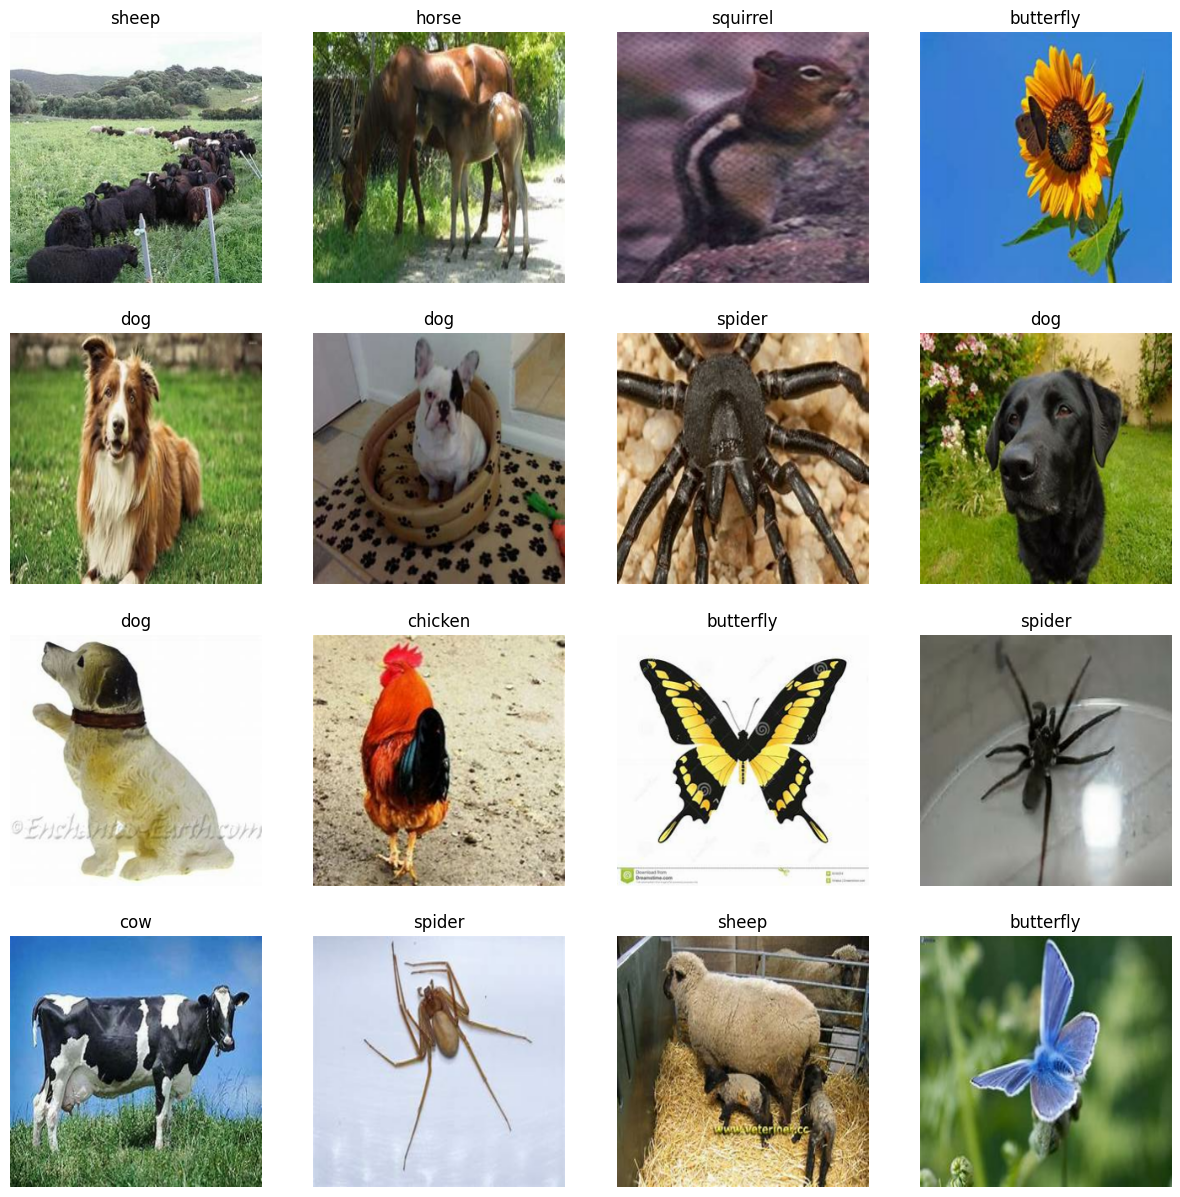

In [ ]:
#Representación gráfica de algunos ejemplos

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br>
Como puede observarse, todas las imágenes son ahora de la misma dimensión. Para ello, se ha llevado a cabo un redimensionado pero sin mantener el aspect ratio y evitando los recortes de las imágenes, ya que se podrían perder características vitales para su clasificación.<br>
    El número de instancias de cada dataset es de 18328 para el conjunto de entrenamiento, 3925 para el conjunto de validación y 3926 para el conjunto de test, que representan aproximadamente un 75%, 15% y 15% respectivamente del total de imágenes.
</div>

## 2. Modelo ANN (1,5 puntos)

En este apartado, vamos a entrenar y evaluar un modelo muy sencillo completamente conectado para establecer un resultado de referencia.

Dado que en una red neuronal artificial las entradas son unidimensionales, lo primero que tenemos que hacer es redimensionar los datos de entrada (las imágenes) para convertirlos en arrays de una dimensión.

Como trabajar con imágenes de tamaño 299x299 en una red completamente conectada implicaría entrenar un número de parámetros excesivamente elevado definiremos un modelo en el que se realizará previamente un redimensionado de las imágenes de entrada a un tamaño de 32x32 y un achatamiento (*flattening*) de los píxeles para así generar un vector unidimensional de tamaño 3072 (32x32x3).

Posteriormente entrenaremos un clasificador (una red completamente conectada) para llevar a cabo la clasificación de nuestros datos.

En este apartado utilizaremos las capas [Resizing](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/resizing/), [Rescaling](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/), [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/), [Dense](https://keras.io/api/layers/core_layers/dense/) y [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) de keras.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio:</strong> A partir del modelo <strong>funcional</strong> de keras (y la clase <code>Model()</code>), implementa una red con las siguientes características:
    <ul>
        <li>Una capa que reduzca las dimensiones de entrada de (299,299) a (32,32)</li>
        <li>Una capa de reescalado para conseguir que los valores de la imagen estén entre 0 y 1</li>
        <li>Una capa Flatten para convertir la imagen en un vector de 3072 posiciones</li>
        <li>Una capa completamente conectada con 2048 neuronas y activación ReLU.</li>
        <li>Una capa de Dropout (con probabilidad 0.5)</li>
        <li>Una capa completamente conectada con 1024 neuronas y activación ReLU.</li>
        <li>Una capa de Dropout (con probabilidad 0.5)</li>
        <li>Una capa de salida completamente conectada correspondiente a la clasificación final cuyo número de neuronas debe ser igual al múmero de clases de la base de datos y con la función de activación adecuada para llevar a cabo esta tarea de clasificación.</li>
    </ul>
        
Compilar y entrenar el modelo siguiendo las siguientes indicaciones:
     <ul>
         <li>Utilizar el optimizador Adam con  <i>learning rate</i> de 0.0001 (1e-4).</li>
         <li>Entrenar durante 100 épocas utilizando  <i>EarlyStopping</i> con una persistencia (paciencia) de 10 épocas, monitorizando la función de pérdida en el conjunto de validación, y guardando los pesos que mejor resultado hayan obtenido.</li>
         <li>Monitorizar la métrica  <i>accuracy</i> durante entrenamiento y validación.</li>
         <li>Mostrar las gráficas de accuracy y loss. En cada gráfica debe visualizarse la curva de entrenamiento y la de validación. NOTA: Se recomienda hacer una función que imprima ambas gráficas para poder reutilizarla en próximos apartados.</li>
         <li>Realizar la evaluación del modelo una vez ha finalizado el entrenamiento para mostrar la pérdida y la exactitud final sobre los datos de test.</li>
    </ul>
        Preguntas a responder:
<ul>
    <li>¿Qué número de neuronas se recomienda utilizar en las capas intermedias según los módulos teóricos de la asignatura?</li>
    <li>¿Se ha realizado así en este ejercicio?</li>
    <li>¿Cúal es el número de parámetros a entrenar? ¿y el tiempo de entrenamiento?</li>
    <li>¿Qué accuracy se obtiene con este modelo?</li>
    <li>Comenta los resultados analizando también las curvas de entrenamiento. ¿Qué fenómeno se puede apreciar? ¿A qué puede ser debido?</li>
</ul>        
        <br/>    
    <strong> NOTA: se recomienda, al final de la creación de cada modelo, utilizar la función <code>summary()</code> para comprobar la estructura de la red creada, así como el numero de parámetros que se deben entrenar. Se recomienda hacerlo en todos los ejercicios.</strong>
</div>

In [ ]:
# Definición de la red
input_layer = keras.Input(shape=(299, 299, 3), name="image")

x = Resizing(32,32)(input_layer)
x = Rescaling(1./255)(x)
x = Flatten()(x)
x = Dense(2048, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(10, activation="softmax")(x)

ann_model = keras.Model(input_layer, x, name="model")
ann_model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     6,293,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,401,930 (32.05 MB)

 Trainable params: 8,401,930 (32.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compilación de la red
opt = Adam(learning_rate=0.0001)

ann_model.compile(
    optimizer=opt,
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

stopping =  EarlyStopping(monitor='val_loss',
                            patience=10,
                            verbose=1,
                            restore_best_weights=True)

In [ ]:
# Entrenamiento de la red
t = time.time()
ann_history = ann_model.fit(train_ds,
                            epochs=100,
                            callbacks=[stopping],
                            verbose=1,
                            validation_data=val_ds)
print ("Tiempo de entrenamiento: ",time.time() - t, "segundos.")

Epoch 1/100


I0000 00:00:1710855183.706679     666 service.cc:145] XLA service 0x7cb670006770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1710855183.706752     666 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/287 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - accuracy: 0.1042 - loss: 2.7131

I0000 00:00:1710855187.460907     666 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


287/287 ━━━━━━━━━━━━━━━━━━━━ 42s 128ms/step - accuracy: 0.1798 - loss: 2.3201 - val_accuracy: 0.2726 - val_loss: 2.0692
Epoch 2/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - accuracy: 0.2426 - loss: 2.1177 - val_accuracy: 0.2927 - val_loss: 1.9943
Epoch 3/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 34s 116ms/step - accuracy: 0.2729 - loss: 2.0454 - val_accuracy: 0.3203 - val_loss: 1.9316
Epoch 4/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 33s 114ms/step - accuracy: 0.2918 - loss: 1.9987 - val_accuracy: 0.3437 - val_loss: 1.9043
Epoch 5/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - accuracy: 0.3028 - loss: 1.9585 - val_accuracy: 0.3445 - val_loss: 1.9004
Epoch 6/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - accuracy: 0.3143 - loss: 1.9326 - val_accuracy: 0.3638 - val_loss: 1.8692
Epoch 7/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - accuracy: 0.3262 - loss: 1.9049 - val_accuracy: 0.3633 - val_loss: 1.8366
Epoch 8/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - accuracy: 0.3302 - loss: 1.893

In [ ]:
# Plot del training loss i l'accuracy
def plot_training(n_epochs, mfit):
    N = n_epochs
    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    fig.suptitle('Training Loss and Accuracy')

    ax1.plot(np.arange(0, N), mfit.history["accuracy"], label="train")
    ax1.plot(np.arange(0, N), mfit.history["val_accuracy"], label="val")
    ax1.set_title("Accuracy")
    ax1.set_xlabel("Epoch #")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc="lower right")

    ax2.plot(np.arange(0, N), mfit.history["loss"], label="train")
    ax2.plot(np.arange(0, N), mfit.history["val_loss"], label="val")
    ax2.set_title("Loss")
    ax2.set_xlabel("Epoch #")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="upper right")

    plt.show()

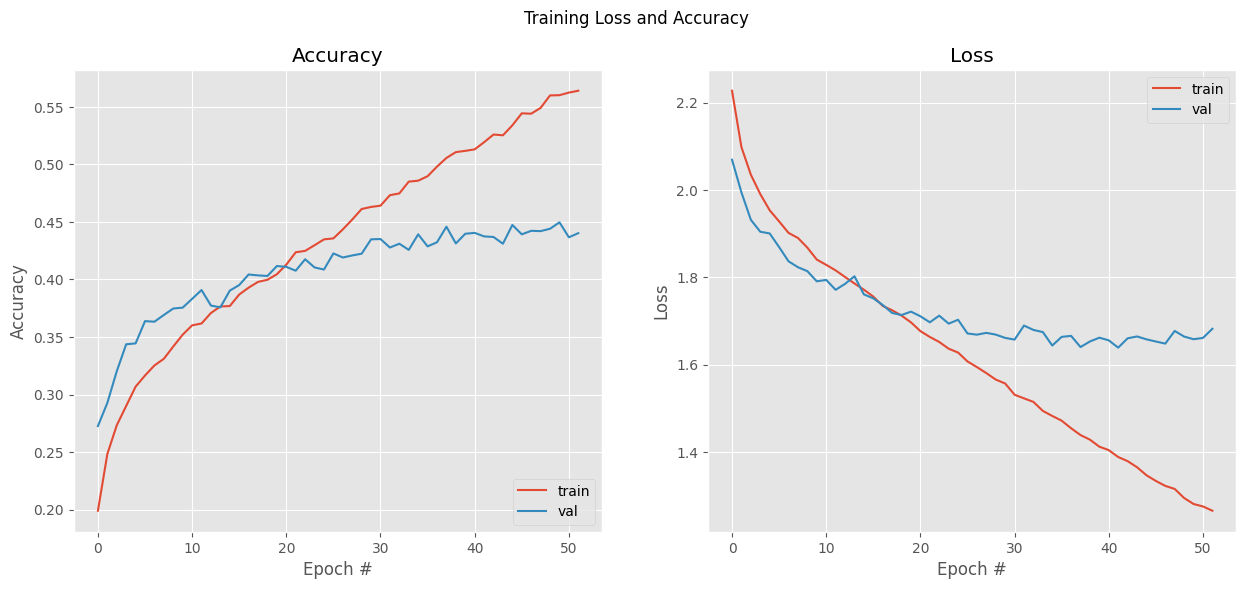

----------
Loss: 1.76
Accuracy: 40.32 %


In [ ]:
n_epochs = len(ann_history.history["loss"])
plot_training(n_epochs, ann_history)

score = ann_model.evaluate(test_ds, verbose=0)
print ("-"*10)
print ("Loss: {:.2f}".format((score[0])))
print ("Accuracy: {:.2f} %".format(score[1]*100))

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
    
- Según se cita en los módulos teóricos de la asignatura 'se suele utilizar un número de neuronas en las capas ocultas que se encuentre entre una y dos veces el número de entradas de la red' cosa que se cumple en este apartado (2048 neuronas de la primera capa más 1024 de la segunda capa hacen un total de 3072, que es igual a la dimensión de los datos de entrada).
    
- El número de parámetros a entrenar es de 8,401,930.
    
- La precisión obtenida es del 40.32%
    
- El tiempo de entrenamiento es de 1733 segundos (52 épocas).
    
- En las gráficas se aprecia un sobreentrenamiento que empieza entre las épocas 15 y 20, que es cuando las curvas de entrenamiento y validación empiezan a separarse. Este error se produce cuando la red se adapta perfectamente a los datos de train pero no es capaz de generalizar con ejemplos nuevos (los del conjunto de validación) y puede venir provocado por diversos factores: un conjunto de datos no demasiado extenso, una red sobredimensionada, ...
<br><br>
</div>

## 3. Red convolucional pequeña (2 puntos)

Dadas las bajas prestaciones del modelo anterior vamos a probar otro tipo de redes con el objetivo de obtener unos mejores resultados en la tarea de clasificación que debemos llevar a cabo.

Las redes convolucionales (CNN) son especialmente adecuadas para modelar datos donde hay patrones en 2 dimensiones, como es el caso de las imágenes.

En la tarea de clasificación, la estructura de una CNN se divide en dos grandes bloques:

* **Bloque extractor de características**: En este bloque se generan diferentes niveles de abstracción de la imagen de entrada mediante capas convolucionales. Cuanto más profundas son estas capas, más preparadas están para la tarea de clasificación.
* **Clasificador**: Este bloque está formado por capas totalmente conectadas, la salida de deste bloque será la probabilidad asociada a cada clase.

En el apartado anterior, el bloque "extractor de características" era extremadamente simple, por no decir inexistente. En este apartado, vamos a hacer uso de capas convolucionales para poder aprender mejores abstracciones de las imágenes de entrada con el fin de mejorar su clasificación.

En este apartado utilizaremos las capas [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/),  [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/), [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/), [Dense](https://keras.io/api/layers/core_layers/dense/) y [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) de keras.

**Nota: Se recomienda, a partir de este punto realizar el entrenamiento en una máquina con GPU (puede activarse en plataformas como Google Colab o Kaggle) con el fin de reducir los tiempos de entrenamiento.**

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio [2 puntos]:</strong> Implementa un modelo <strong>secuencial</strong> de Keras (a partir de la clase <code>Sequential()</code>) con las siguientes especificaciones:
    <ul>
        <li>Un bloque extractor de características que conste de:
            <ul>
                <li>Una capa de entrada de dimensiones adecuadas a los datos.</li>
                <li>Una capa de rescalado para conseguir que los valores de la imagen estén entre 0 y 1.</li>
                <li>3 capas convolucionales con tamaño de kernel (3x3). Se utilizará padding '<i>same</i>' y activación ReLU. El número de filtros para cada capa convolucional será 16, 32 y 64 respectivamente.</li>
                <li>A cada capa convolucional le sigue una capa de <i>Max Pooling2D</i></li>
                <li>Una capa de Dropout (con probabilidad 0.2)</li>
            </ul></li>
        <li>El clasificador final sigue la estructura del modelo del apartado anterior:
            <ul>
                <li>Una capa Flatten.</li>
                <li>Una capa completamente conectada de 64 neuronas y activación ReLU</li>
                <li>Una capa de Dropout (con probabilidad 0.5)</li>
                <li>Una capa de salida completamente conectada correspondiente a la clasificación final cuyo número de neuronas debe ser igual al múmero de clases de la base de datos y con la función de activación adecuada para llevar a cabo esta tarea de clasificación.</li>
            </ul></li>
    </ul>
    
Compilar y entrenar el modelo siguiendo las siguientes indicaciones:
     <ul>
         <li>Utilizar el optimizador Adam con  <i>learning rate</i> de 0.0001 (1e-4).</li>
          <li>Entrenar durante 100 épocas utilizando  <i>EarlyStopping</i> con una persistencia de 10 épocas, monitorizando la función de pérdida en el conjunto de validación, y guardando los pesos que mejor resultado hayan obtenido.</li>
         <li> Utilizaremos el callback ReduceLROnPlateau (que nos permite ir reduciendo el learning rate paulatinamente) monitorizando la función de pérdida en el conjunto de validación, con una persistencia de 5 épocas, un factor de 0.2 y un learning rate mínimo de 0.000001 (1e-6).
         <li>Monitorizar la métrica  <i>accuracy</i> durante entrenamiento y validación.</li>
         <li>Mostrar las gráficas de <i>accuracy</i> y <i>loss</i>. En cada gráfica debe visualizarse la curva de entrenamiento y la de validación.</li>
         <li>Realizar la evaluación del modelo una vez ha finalizado el entrenamiento para mostrar la pérdida y la exactitud final sobre los datos de test.</li>
    </ul>
    Preguntas a responder:
<ul>
    <li>¿Cúal es el número de parámetros a entrenar? ¿y el tiempo de entrenamiento?</li>
    <li>¿Qué accuracy se obtiene con este modelo?</li>
    <li>Comenta de nuevo las gráficas de las curvas de entrenamiento. ¿Se sigue apreciando el mismo fenómeno?</li>
</ul>
</div>

In [ ]:
# Definición de la red
num_of_classes = 10

cnn_model = Sequential()
# Feature extractor
cnn_model.add(Input(shape=(299,299,3)))
cnn_model.add(Rescaling(1./255))
cnn_model.add(Conv2D(16, 3, padding='same', activation='relu'))
cnn_model.add(MaxPooling2D())
cnn_model.add(Conv2D(32, 3, padding='same', activation='relu'))
cnn_model.add(MaxPooling2D())
cnn_model.add(Conv2D(64, 3, padding='same', activation='relu'))
cnn_model.add(MaxPooling2D())
cnn_model.add(Dropout(0.2))
# Classificator
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_of_classes, name="outputs", activation = "softmax"))

cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 299, 299, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 149, 149, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     5,607,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,631,722 (21.48 MB)

 Trainable params: 5,631,722 (21.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compilación de la red
opt = Adam(learning_rate=0.0001)

cnn_model.compile(
    optimizer=opt,
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

stopping =  EarlyStopping(monitor='val_loss',
                            patience=10,
                            verbose=1,
                            restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              min_lr=1e-6)

In [ ]:
# Entrenamiento
t = time.time()
cnn_history = cnn_model.fit(train_ds,
                            epochs=100,
                            callbacks=[stopping, reduce_lr],
                            verbose=1,
                            validation_data=val_ds)
print ("Tiempo de entrenamiento: ",time.time() - t, "segundos.")

Epoch 1/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 45s 136ms/step - accuracy: 0.1666 - loss: 2.2864 - val_accuracy: 0.2191 - val_loss: 2.1452 - learning_rate: 1.0000e-04
Epoch 2/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 33s 113ms/step - accuracy: 0.2146 - loss: 2.1504 - val_accuracy: 0.2634 - val_loss: 2.0300 - learning_rate: 1.0000e-04
Epoch 3/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 34s 117ms/step - accuracy: 0.2688 - loss: 2.0635 - val_accuracy: 0.3600 - val_loss: 1.9408 - learning_rate: 1.0000e-04
Epoch 4/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 33s 112ms/step - accuracy: 0.2987 - loss: 1.9935 - val_accuracy: 0.3885 - val_loss: 1.8411 - learning_rate: 1.0000e-04
Epoch 5/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 34s 115ms/step - accuracy: 0.3349 - loss: 1.9022 - val_accuracy: 0.4484 - val_loss: 1.6506 - learning_rate: 1.0000e-04
Epoch 6/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 33s 113ms/step - accuracy: 0.3954 - loss: 1.7576 - val_accuracy: 0.4889 - val_loss: 1.5428 - learning_rate: 1.0000e-04
Epoch 7/100
287/287 ━━━━━━━━━━━━━━━━━━━━

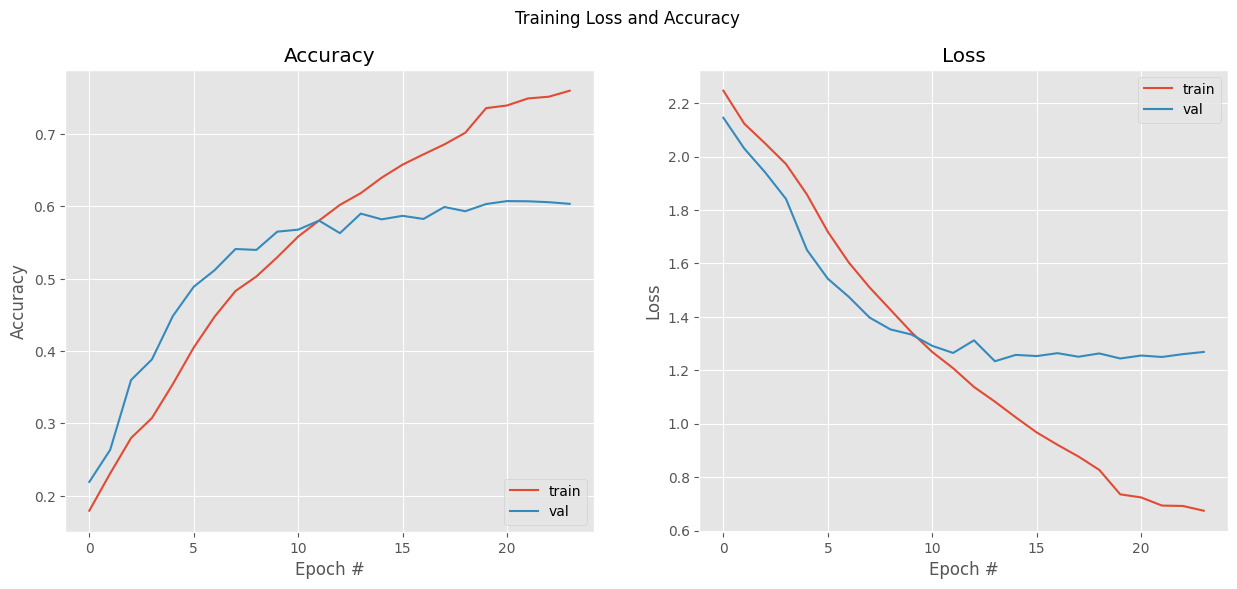

----------
Loss: 1.30
Accuracy: 56.72 %


In [ ]:
# Resultados
n_epochs = len(cnn_history.history["loss"])
plot_training(n_epochs, cnn_history)

score = cnn_model.evaluate(test_ds, verbose=0)
print ("-"*10)
print ("Loss: {:.2f}".format((score[0])))
print ("Accuracy: {:.2f} %".format(score[1]*100))

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
    

- El número de parámetros a entrenar se ha reducido a 5,631,722 (un 30-40% menos que en la ANN).
    
- La precisión obtenida a aumentado al 56.72%, un aumento considerable respecto a la ANN aunque aún nos encontramos lejos de un buen resultado.
    
- El tiempo de entrenamiento se ha reducido más de la mitad: 832 segundos (24 épocas).
    
- Aunque las prestaciones han mejorado ostensiblemente (gracias a que las redes convolucionales se adaptan mejor al tipo de datos de nuestra base de datos), en las gráficas se sigue apreciando un sobreentrenamiento muy marcado a partir de la época 11-12 aproximadamente
<br><br>
</div>

## 4. Aumentación de los datos (1 punto)

Una forma de solucionar en parte el problema que nos hemos encontrado en el apartado anterior es conseguir entrenar el modelo con un número mayor de datos.

Como no disponemos de más datos (en cada epoch utilizamos todas las imágenes del conjunto de training) una forma de aumentar el número de instancias consiste en realizar algún tipo de técnica de aumentación.

A tal fin, Keras dispone de varias capas como RandomFlip, RandomRotation, RandomZoom, ...

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio [0.5 puntos]:</strong> Implementa un modelo <strong>secuencial</strong> de Keras (a partir de la clase <code>Sequential()</code>) con las siguientes capas:
    <ul>
        <li>Una capa RandomFlip que voltee las imágenes sólo horizontalmente.
        <li>Una capa RandomRotation con factor 0.1.
    </ul>

Selecciona una imagen del conjunto de datos de entrenamiento y pásala a través del modelo creado. Representa gráficamente las imágenes de salida comprobando que se producen las operaciones implementadas sobre ella.
</div>

In [ ]:
# Modelo de aumentación
data_augmentation = tf.keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1)
])

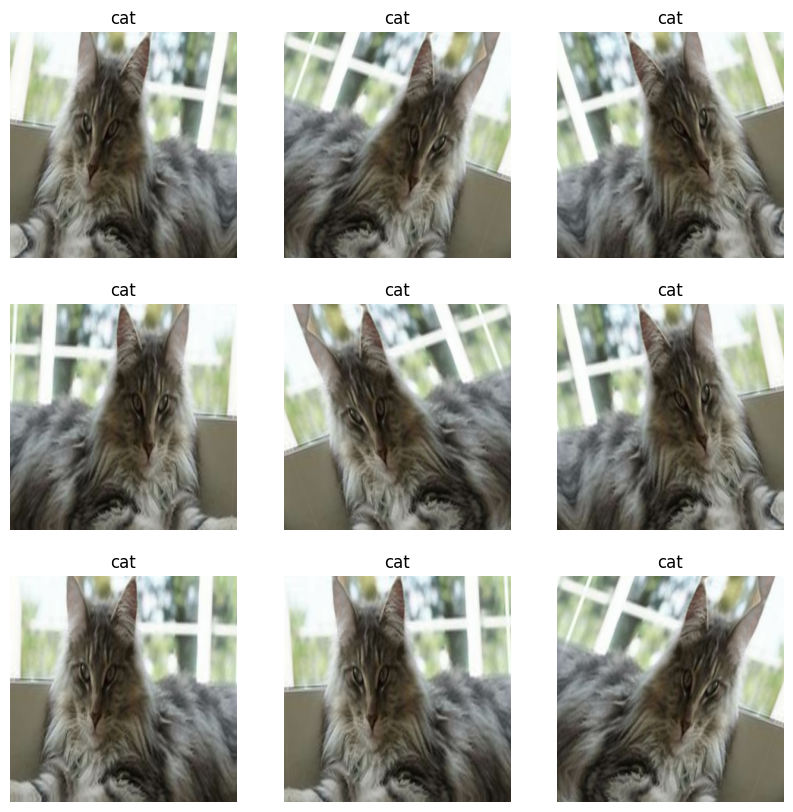

In [ ]:
# Representación de los datos aumentados
classes = train_ds.class_names

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(classes[int(np.argmax(labels[0]))])
        plt.axis("off")

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio [0.5 puntos]:</strong> Intercala este modelo entre la capa de Rescaling y la primera capa Conv2D del modelo del ejercicio anterior (modelo CNN).
    
Compilar y entrenar el modelo siguiendo las mismas indicaciones que en el ejercicio anterior excepto el learning rate inicial, que lo aumentaremos:
     <ul>
         <li>Utilizar el optimizador Adam con <i>learning rate</i> de 0.001 (1e-3).</li>
         <li>Entrenar durante 100 épocas utilizando <i>EarlyStopping</i> con una persistencia de 10 épocas, monitorizando la función de pérdida en el conjunto de validación, y guardando los pesos que mejor resultado hayan obtenido.</li>
         <li> Utilizar el callback ReduceLROnPlateau monitorizando la función de pérdida en el conjunto de validación, con una persistencia de 5 épocas, un factor de 0.2 y un learning rate mínimo de 0.000001 (1e-6).</li>
         <li>Monitorizar la métrica  <i>accuracy</i> durante entrenamiento y validación.</li>
         <li>Mostrar las gráficas de <i>accuracy</i> y <i>loss</i>. En cada gráfica debe visualizarse la curva de entrenamiento y la de validación.</li>
         <li>Realizar la evaluación del modelo una vez ha finalizado el entrenamiento para mostrar la pérdida y la exactitud final sobre los datos de test.</li>
    </ul>
    Preguntas a responder:
<ul>
    <li>¿Cúal es el número de parámetros a entrenar? ¿y el tiempo de entrenamiento?</li>
    <li>¿Qué accuracy se obtiene con este modelo?</li>
    <li>Comenta de nuevo las gráficas del entrenamiento. ¿Se ha conseguido solventar el problema?</li>
</ul>
</div>

In [ ]:
# Definición de la red
num_of_classes = 10

cnn_model = Sequential()
# Feature extractor
cnn_model.add(Input(shape=(299,299,3)))
cnn_model.add(Rescaling(1./255))
cnn_model.add(data_augmentation)
cnn_model.add(Conv2D(16, 3, padding='same', activation='relu'))
cnn_model.add(MaxPooling2D())
cnn_model.add(Conv2D(32, 3, padding='same', activation='relu'))
cnn_model.add(MaxPooling2D())
cnn_model.add(Conv2D(64, 3, padding='same', activation='relu'))
cnn_model.add(MaxPooling2D())
cnn_model.add(Dropout(0.2))
# Classificator
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_of_classes, name="outputs", activation = "softmax"))

cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 299, 299, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 149, 149, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     5,607,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,631,722 (21.48 MB)

 Trainable params: 5,631,722 (21.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compilación de la red
opt = Adam(learning_rate=0.001)

cnn_model.compile(
    optimizer=opt,
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

stopping =  EarlyStopping(monitor='val_loss',
                            patience=10,
                            verbose=1,
                            restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              min_lr=1e-6)

In [ ]:
# Entrenamiento
t = time.time()
cnn_history = cnn_model.fit(train_ds,
                            epochs=100,
                            callbacks=[stopping, reduce_lr],
                            verbose=1,
                            validation_data=val_ds)
print ("Tiempo de entrenamiento: ",time.time() - t, "segundos.")

Epoch 1/100


2024-03-19 15:44:04.242807: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


287/287 ━━━━━━━━━━━━━━━━━━━━ 41s 121ms/step - accuracy: 0.2033 - loss: 2.2866 - val_accuracy: 0.3513 - val_loss: 1.8705 - learning_rate: 0.0010
Epoch 2/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 34s 118ms/step - accuracy: 0.3229 - loss: 1.9436 - val_accuracy: 0.4173 - val_loss: 1.7222 - learning_rate: 0.0010
Epoch 3/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 34s 117ms/step - accuracy: 0.3702 - loss: 1.8135 - val_accuracy: 0.4599 - val_loss: 1.6005 - learning_rate: 0.0010
Epoch 4/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 34s 117ms/step - accuracy: 0.3924 - loss: 1.7353 - val_accuracy: 0.4912 - val_loss: 1.5009 - learning_rate: 0.0010
Epoch 5/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 34s 116ms/step - accuracy: 0.4107 - loss: 1.6595 - val_accuracy: 0.5261 - val_loss: 1.4248 - learning_rate: 0.0010
Epoch 6/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 34s 118ms/step - accuracy: 0.4350 - loss: 1.6154 - val_accuracy: 0.5294 - val_loss: 1.4106 - learning_rate: 0.0010
Epoch 7/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 34s 118ms/step - accuracy: 0.4504 -

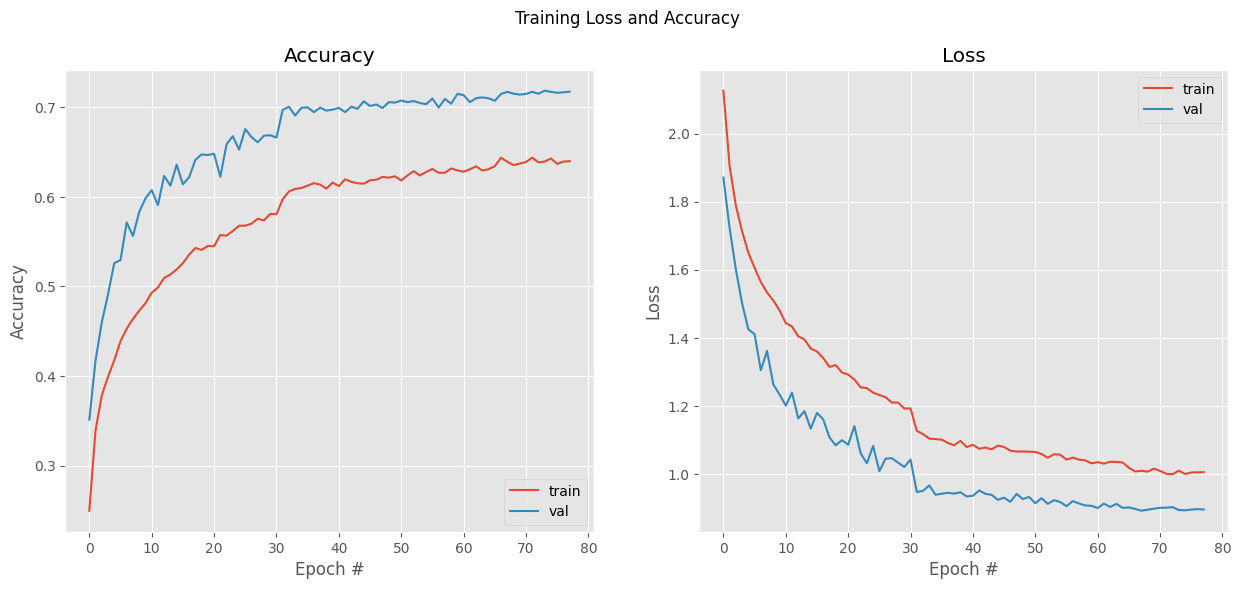

----------
Loss: 0.95
Accuracy: 69.87 %


In [ ]:
# Resultados
n_epochs = len(cnn_history.history["loss"])
plot_training(n_epochs, cnn_history)

score = cnn_model.evaluate(test_ds, verbose=0)
print ("-"*10)
print ("Loss: {:.2f}".format((score[0])))
print ("Accuracy: {:.2f} %".format(score[1]*100))

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
    

- El número de parámetros a entrenar se mantiene igual que en el ejercicio anterior (5,631,722 parámetros) ya que no se introducido en la red ninguna capa entrenable.
    
- La precisión obtenida a aumentado al 69.87% un aumento considerable respecto a la misma red entrenada sin aumentación.
    
- El tiempo de entrenamiento ha aumentado ostensiblemente: 2673 segundos (un 60% más que la ANN y entre 3 y 4 veces el de la CNN sin aumentación de datos) pero es debido a que ahora hemos pasado muchas instancias por la red para llevar a cabo su entrenamiento.
    
- Se puede apreciar en las gráficas que, aunque ahora las gráficas de train y de validación siguen comportamientos parecidos, las gráficas de validación son mejores que las de entrenamiento, cosa que puede ser debida a un exceso de regularización.
<br><br>
</div>

## 5. Red InceptionV3 y transfer learning (2 puntos)

Las redes neuronales convolucionales profundas nos brindan la posibilidad de mejorar la capacidad de aprendizaje de un modelo. Algunas arquitecturas comunes, pueden incluir cientos de capas convolucionales. No obstante, entrenar estas arquitecturas desde cero puede resultar costoso tanto en términos de tiempo como de recursos, además de requerir conjuntos de datos bastante grandes.

### 5.1. Transfer Learning con aumentación de los datos
En este apartado, aplicaremos [transfer learning](https://keras.io/guides/transfer_learning/) con el fin de ahorrarnos parte de dicho entrenamiento. Esta metodología consiste en aprovechar los pesos de un modelo entrenado en otra base de datos y para otra tarea. En concreto, utilizaremos el modelo [InceptionV3](https://keras.io/api/applications/inceptionv3/) preentrenado en [Imagenet](http://www.image-net.org/), y lo adaptaremos para clasificar las 10 categorías de nuestra base de datos. En la versión de InceptionV3 de keras existe la opción de cargar los pesos entrenados en Imagenet sin las capas totalmente conectadas de la parte final de la red (opción <code>include_top = False</code>). Nosotros substituiremos esas capas y reentrenaremos el conjunto con el resto de pesos congelados.

Dado que el número de parámetros que se van a utilizar es mucho más extenso, se propone realizar una aumentación de los datos de forma más profunda,

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio[0.5 puntos]:</strong> Implementa un modelo <strong>secuencial</strong> de Keras (a partir de la clase <code>Sequential()</code>) con las siguientes capas:
            <ul>
                <li>Una capa RandomFlip que voltee las imágenes sólo horizontalmente.</li>
                <li>Una capa RandomRotation con factor 0.1.</li>
                <li>Una capa RandomZoom con factor 0.1.</li>
                <li>Una capa RandomContrast con factor 0.1.</li>
            </ul>
    
 Selecciona una imagen del conjunto de datos de entrenamiento y pásala a través del modelo creado. Representa gráficamente las imágenes de salida comprobando que se producen las operaciones implementadas sobre la imagen original.
</div>

<br>

In [ ]:
# Modelo de aumentación
data_augmentation = tf.keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1)
])

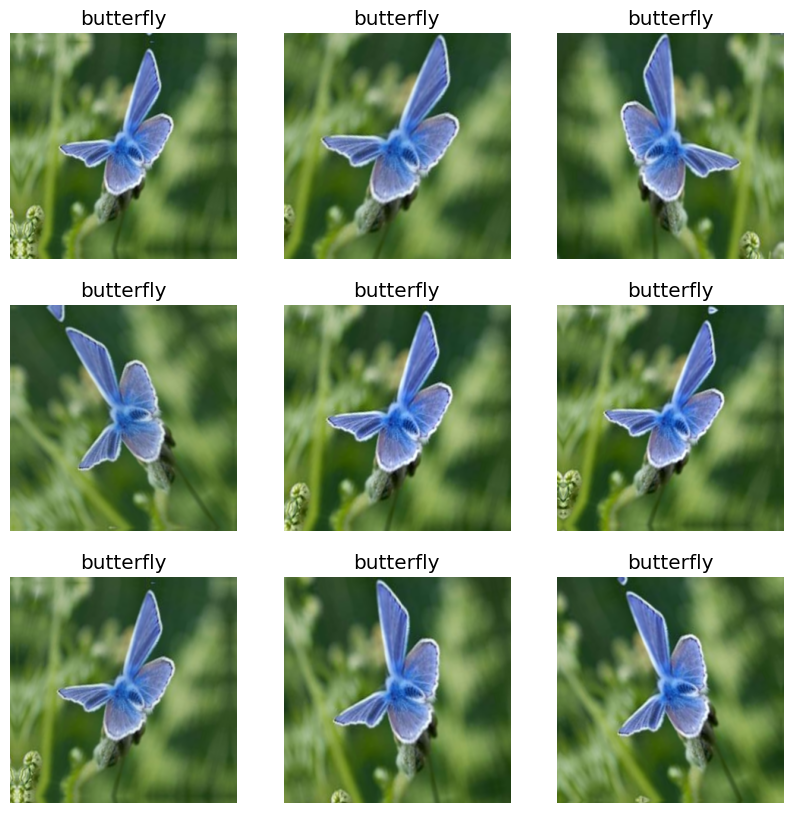

In [ ]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(classes[int(np.argmax(labels[0]))])
        plt.axis("off")

Para reutilizar el modelo correctamente es necesario preprocesar los datos tal y como se hizo durante el entrenamiento en la base de datos original. Keras nos facilita aplicar la normalización en el caso de modelos preentrenados; para el caso de InceptionV3 dicha normalización se lleva a cabo añadiendo <code>keras.applications.inception_v3.preprocess_input</code> entre las entradas y el modelo. La función <code>inception_v3.preprocess_input</code> escalará los píxeles de entrada entre -1 y 1 (tened en cuenta que la función se debe aplicar sobre imágenes con rango dinámico de 0 a 255).
<br><br>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio[1 punto]:</strong> Implementa una red siguiendo los siguientes pasos:
    <ul>
        <li>Partir del modelo InceptionV3 con los pesos entrenados en Imagenet y congelarlos</li>
        <li>Añadir, previo al modelo base: la capa de 'data_augmentation' seguida de la capa 'preprocess_input'.</li>
        <li>Substituir las últimas capas completamente conectadas por: una capa de 'GlobalAveragePooling2D()' seguida de dos capas plenamente conectadas, una de 1024 neuronas con activación ReLU, y una última capa con el número de neuronas adecuado para llevar a cabo la tarea de clasificación sobre nuestra base de datos y la función de activación adecuada.</li>
    </ul>
Compilar y entrenar el modelo siguiendo las siguientes indicaciones:
     <ul>
         <li>Utilizar el optimizador RMSprop con  <i>learning rate</i> de 0.0001 (1e-4).</li>
         <li>Entrenar durante 100 épocas utilizando  <i>EarlyStopping</i> con una persistencia de 10 épocas, monitorizando la pérdida en el conjunto de validación, y guardando los pesos que mejor resultado hayan obtenido.</li>
         <li>Utilizar el callback ReduceLROnPlateau monitorizando la función de pérdida en el conjunto de validación con una persistencia de 5 épocas, un factor de 0.2 y un learning rate mínimo de 0.000001 (1e-6).</li>
         <li>Monitorear la métrica  <i>accuracy</i> durante entrenamiento y validación.</li>
         <li>Mostrar las gráficas de accuracy y loss. En cada gráfica debe visualizarse la curva de entrenamiento y la de validación.</li>
         <li>Realizar la evaluación del modelo una vez ha finalizado el entrenamiento para mostrar la pérdida y la exactitud final sobre los datos de test.</li>
    </ul>
    Preguntas a responder:
<ul>
    <li>¿Cúal es el número de parámetros a entrenar? ¿y el tiempo de entrenamiento?</li>
    <li>¿Qué accuracy se obtiene con este modelo?</li>
    <li>En base a las curvas de las gráficas, comenta los resultados.</li>
</ul>
</div>

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

## Loading InceptionV3 model
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(299,299,3))
base_model.trainable = False ## Not trainable weights
base_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 149, 149,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d_3[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
# Definición de la red
input_layer = keras.Input(shape=(299, 299, 3), name="image")
x = data_augmentation(input_layer)
x = preprocess_input(x)
x = base_model(x, training = False)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(10, activation='softmax')(x)

inception_model = keras.Model(inputs=[input_layer], outputs=[predictions])
inception_model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,911,210 (91.21 MB)

 Trainable params: 2,108,426 (8.04 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
# Compilación de la red
opt = RMSprop(learning_rate=0.0001)

inception_model.compile(
    optimizer=opt,
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

stopping =  EarlyStopping(monitor='val_loss',
                            patience=10,
                            verbose=1,
                            restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              min_lr=1e-6)

In [ ]:
# Entrenamiento de la red
t = time.time()
inception_history = inception_model.fit(train_ds,
                            validation_data=val_ds,
                            epochs=100,
                            callbacks=[stopping, reduce_lr])
print ("Tiempo de entrenamiento: ",time.time() - t, "segundos.")

Epoch 1/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 82s 241ms/step - accuracy: 0.8703 - loss: 0.5493 - val_accuracy: 0.9641 - val_loss: 0.1157 - learning_rate: 1.0000e-04
Epoch 2/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 63s 216ms/step - accuracy: 0.9529 - loss: 0.1558 - val_accuracy: 0.9740 - val_loss: 0.0972 - learning_rate: 1.0000e-04
Epoch 3/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 62s 216ms/step - accuracy: 0.9583 - loss: 0.1344 - val_accuracy: 0.9722 - val_loss: 0.1068 - learning_rate: 1.0000e-04
Epoch 4/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 63s 217ms/step - accuracy: 0.9619 - loss: 0.1174 - val_accuracy: 0.9748 - val_loss: 0.0957 - learning_rate: 1.0000e-04
Epoch 5/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 63s 217ms/step - accuracy: 0.9628 - loss: 0.1161 - val_accuracy: 0.9750 - val_loss: 0.0991 - learning_rate: 1.0000e-04
Epoch 6/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 63s 217ms/step - accuracy: 0.9645 - loss: 0.1111 - val_accuracy: 0.9766 - val_loss: 0.0892 - learning_rate: 1.0000e-04
Epoch 7/100
287/287 ━━━━━━━━━━━━━━━━━━━━

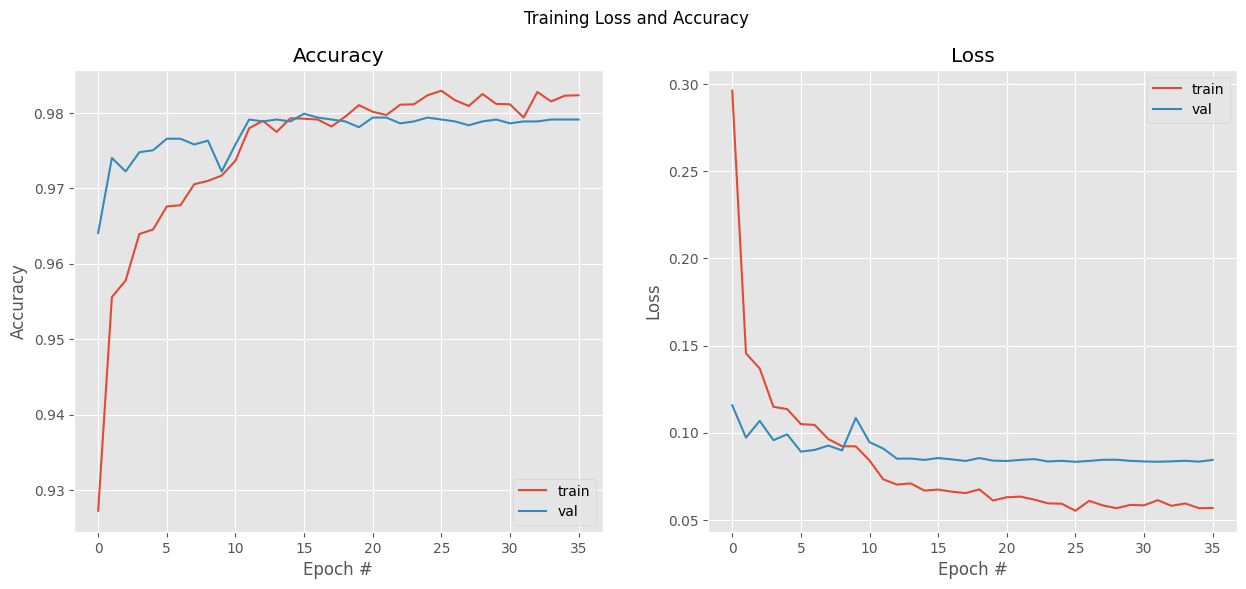

----------
Loss: 0.05
Accuracy: 98.62 %


In [ ]:
# Resultados
n_epochs = len(inception_history.history["loss"])
plot_training(n_epochs, inception_history)

score = inception_model.evaluate(test_ds, verbose=0)
print ("-"*10)
print ("Loss: {:.2f}".format((score[0])))
print ("Accuracy: {:.2f} %".format(score[1]*100))

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
    

- Aunque el número de parámetros total del sistema es muy grande (23,911,210) tan sólo tenemos que entrenar una décima parte (2,108,426) debido a que mantenemos congelados la mayoría de los pesos de la red InceptionV3.
    
- La precisión obtenida ha aumentado hasta el 98.62% estando ya entre los mejores modelos del estado del arte.
    
- El tiempo de entrenamiento (36 épocas en 2291 segundos), aun siendo alto porque volvemos a utilizar aumentación de los datos, es inferior al de la CNN del apartado anterior gracias a que el número de parámetros a entrenar es inferior. Queda demostrado, por tanto, que el Transfer Learning es una buena herramienta para obtener unos muy buenos resultados con un coste computacional menor. Estos resultados tan buenos se obtienen, sobretodo, cuando las redes hayan estado entrenadas en tareas similares o si la red que aporta los pesos ha sido entrenada en tareas más difíciles que la que se lleva a cabo pero que permita generalizar algunas de las características que se extraen de las redes  convolucionales.
    
- Se puede apreciar en las gráficas que, aunque sigue habiendo un poco de sobreentrenamiento este es muy bajo.
<br><br>
</div>

### 5.2. Fine-tunning
Una técnica frecuente, sobretodo cuando la red utilizada no es excesivamente grande, para mejorar los resultados del <i>transfer learning</i> es el denominado <i>fine-tunning</i>,  que consiste en reentrenar la red completa durante unas pocas épocas y con un <i>learning rate</i> muy pequeño.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio[1 punto]:</strong> Volver a compilar el modelo con los siguientes cambios:
    <ul>
        <li>Descongelar los pesos del modelo InceptionV3 poniendo <code>trainable=True</code> (no confundir con <code>traning=True</code>).</li>
    </ul>
Compilar y entrenar el modelo siguiendo las siguientes indicaciones:
     <ul>
         <li>Utilizar el optimizador Adam con  <i>learning rate</i> de 0.00001 (1e-5).</li>
         <li>Entrenar durante 10 épocas utilizando <i>EarlyStopping</i> con una persistencia de 5 épocas monitorizando la <i>accuracy</i> en el conjunto de validación, y guardando los pesos que mejor resultado hayan obtenido.</li>
         <li> Utilizar el callback ReduceLROnPlateau monitorizando la función de pérdida en el conjunto de validación, con una persistencia de 3 épocas, un factor de 0.2 y un learning rate mínimo de 0.0000001 (1e-7).</li>
         <li>Monitorizar la métrica  <i>accuracy</i> durante entrenamiento y validación.</li>
         <li>Mostrar las gráficas de accuracy y loss. En cada gráfica debe visualizarse la curva de entrenamiento y la de validación.</li>
         <li>Realizar la evaluación del modelo una vez ha finalizado el entrenamiento para mostrar la pérdida y la exactitud final sobre los datos de test.</li>
    </ul>
    Preguntas a responder:
<ul>
    <li>¿Cúal es el número de parámetros a entrenar? ¿y el tiempo de entrenamiento?</li>
    <li>¿Qué accuracy se obtiene con este modelo?</li>
    <li>Comenta los resultados teniendo en cuenta el proceso global: <i>transfer lerning</i> + <i> fine-tunning</i>.</li>
    <li>¿Se ha conseguido mejorar los resultados del apartado anterior? ¿Cuál puede ser la explicación?</li>
</ul>  
</div>


In [ ]:
# Definición del modelo
base_model.trainable = True
inception_model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,019,638 (99.26 MB)

 Trainable params: 23,876,778 (91.08 MB)

 Non-trainable params: 34,432 (134.50 KB)

 Optimizer params: 2,108,428 (8.04 MB)

In [ ]:
# Compilación de la red
opt = Adam(learning_rate=0.00001)
inception_model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

stopping =  EarlyStopping(monitor='val_loss',
                            patience=5,
                            verbose=1,
                            restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              min_lr=1e-7)

In [ ]:
# Entrenamiento
t = time.time()
fine_inception_history = inception_model.fit(train_ds,
                                             validation_data=val_ds,
                                             epochs=10,
                                             callbacks=[stopping,reduce_lr])
print ("Tiempo de entrenamiento: ",time.time() - t, "segundos.")

Epoch 1/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 269s 755ms/step - accuracy: 0.9582 - loss: 0.1261 - val_accuracy: 0.9789 - val_loss: 0.0850 - learning_rate: 1.0000e-05
Epoch 2/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 210s 732ms/step - accuracy: 0.9763 - loss: 0.0703 - val_accuracy: 0.9781 - val_loss: 0.0812 - learning_rate: 1.0000e-05
Epoch 3/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 210s 729ms/step - accuracy: 0.9817 - loss: 0.0588 - val_accuracy: 0.9791 - val_loss: 0.0815 - learning_rate: 1.0000e-05
Epoch 4/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 210s 731ms/step - accuracy: 0.9892 - loss: 0.0398 - val_accuracy: 0.9799 - val_loss: 0.0804 - learning_rate: 1.0000e-05
Epoch 5/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 210s 731ms/step - accuracy: 0.9901 - loss: 0.0333 - val_accuracy: 0.9796 - val_loss: 0.0796 - learning_rate: 1.0000e-05
Epoch 6/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 210s 731ms/step - accuracy: 0.9908 - loss: 0.0293 - val_accuracy: 0.9814 - val_loss: 0.0785 - learning_rate: 1.0000e-05
Epoch 7/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 

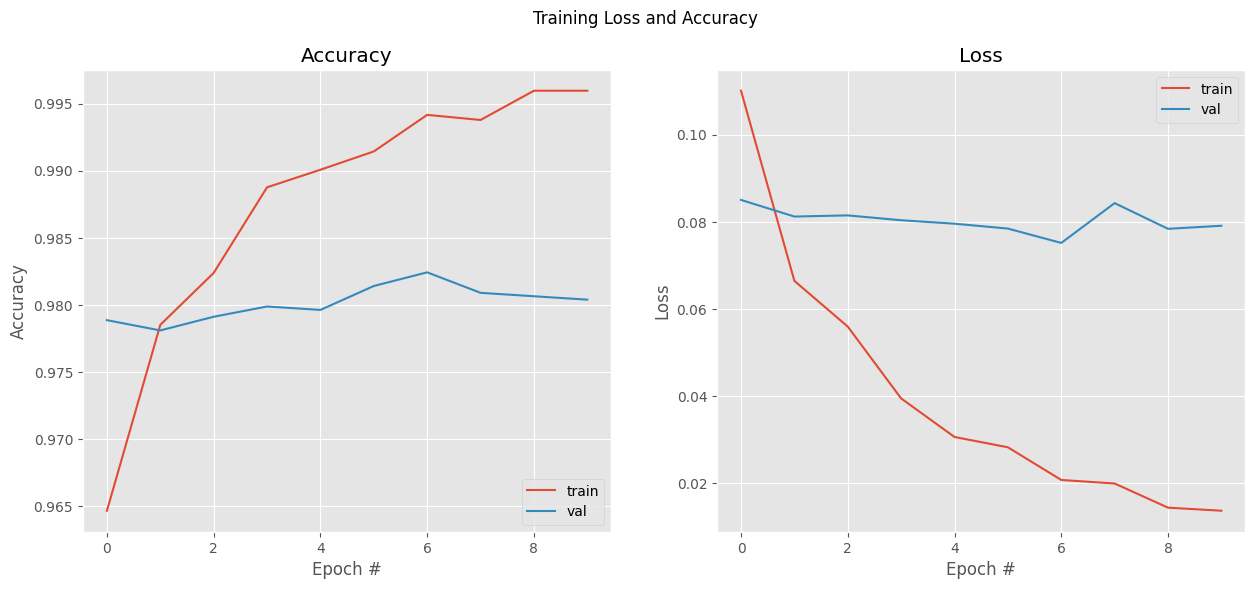

----------
Loss: 0.05
Accuracy: 98.60 %


In [ ]:
# # Resultados
n_epochs = len(fine_inception_history.history["loss"])
plot_training(n_epochs, fine_inception_history)

score = inception_model.evaluate(test_ds, verbose=0)
print ("-"*10)
print ("Loss: {:.2f}".format((score[0])))
print ("Accuracy: {:.2f} %".format(score[1]*100))

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
    

- El número de parámetros (23,876,778) ha aumentado por 10 con respecto al apartado anterior, pero hay que recordar que sólo se entrena durante un máximo de 10 épocas, ya que el objetivo es obtener una mejoría sobre un resultado de partida ya bastante bueno.
    
- La precisión obtenida es prácticamente idéntica a la del modelo anterior, del 98.60%. Dependiendo de la ejecución puede resultar un poco por encima o un poco por debajo. Por tanto no conseguimos mejorar el resultado inicial del Transfer Learning. Esto puede deberse a una base de datos con un número de instancias insuficiente (aún aplicando la aumentación de datos) para entrenar el elevado numero de parámetros de la red InceptionV3.
    
- El tiempo de entrenamiento, aun siendo alto (2161 segundos) no es el más elevado ya que, aunque el tiempo que se tarda en realizar una época sí que es el más alto de toda la PAC, al entrenar menos épocas este se compensa.
    
- Se puede apreciar en las gráficas que se produce una ligera evolución positiva de los indicadores del entrenamiento (la exactitud sube ligeramente y la pérdida se va reduciendo de la misma forma).
<br><br>
</div>

## 6. Inferencia y visualización de resultados (1 punto)

En este apartado vamos a realizar predicciones con el modelo obtenido en el apartado anterior y analizaremos y visualizaremos los resultados obtenidos.

En primer lugar vamos a realizar un estudio estadístico de los resultados. Para ello se pide:

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio[0.5 puntos]:</strong> Utilizando las funciones <code>classification_report</code> y <code>confusion_matrix</code> de la librería Scikit-learn realizad:
    <ul>
        <li>Un estudio estadístico de las medidas más habituales en problemas de clasificación</li>
        <li>Una función que imprima por pantalla de forma visual la matriz de confusión de las 10 clases de la base de datos</li>
        <li>Comentar los resultados obtenidos</li>
    </ul>
</div>

In [ ]:
# Función para generar la matriz de confusión
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matriz de Confusión')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Etiqueta Predicha')
    plt.tight_layout()

In [ ]:
# Estudio estadístico
classes = train_ds.class_names
y_true = []
y_pred = []

for image, y in test_ds:
    y_true.append(np.argmax(y,axis=1))
    prediction = inception_model.predict(image)
    y_pred.append(np.argmax(prediction,axis=1))

y_true = np.concatenate([y for y in y_true])
y_pred = np.concatenate([y for y in y_pred])

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
2/2 ━━━━━━━━

In [ ]:
print(classification_report(y_true,y_pred, target_names=classes))

              precision    recall  f1-score   support

   butterfly       0.96      1.00      0.98       317
         cat       0.99      0.98      0.98       250
     chicken       0.99      1.00      0.99       465
         cow       0.98      0.97      0.98       280
         dog       0.99      0.99      0.99       729
    elephant       0.98      0.98      0.98       217
       horse       0.99      0.99      0.99       393
       sheep       0.99      0.96      0.97       273
      spider       0.99      0.98      0.99       723
    squirrel       1.00      0.99      0.99       279

    accuracy                           0.99      3926
   macro avg       0.98      0.98      0.98      3926
weighted avg       0.99      0.99      0.99      3926



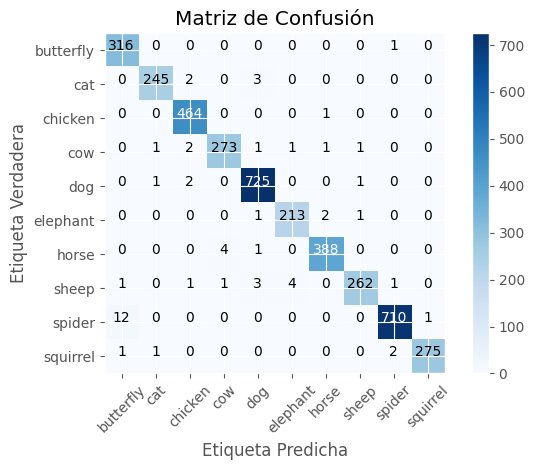

In [ ]:
# Matriz de confusión

# Generar la matriz de confusión
plot_confusion_matrix(y_true, y_pred, classes)

# Mostrar la matriz de confusión
plt.show()

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
    

- En la matriz de confusión podemos observar que los valores más altos están en la diagonal. Cosa que indica la buena bondad del clasificador.
  
- Si bien pudiera parecer inicialmente que los resultados están muy desbalanceados (por la disparidad de colores de la matriz de confusión) cabe recordar que esto viene provocado porque había 2 clases (spider y dog) que ya estaban desbalanceadas en la base de datos inicial porque había muchas más instancias de estas 2 clases que del resto.
    
- Si observamos los resultados arrojados por 'classification_report' vemos que las métricas de la mayoría de clases están muy parejas y apenas hay diferencias sustanciales, cosa que indica que el modelo es capaz de distinguir, con la misma presteza, cualquiera de las clases del dataset.<br><br>
</div>


Para finalizar este ejercicio realizaremos una visualización de algunos resultados elegidos al azar.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio[0.5 puntos]:</strong> Realiza una selección de algunos ejemplos del conjunto de test de la base de datos, realiza una predicción y muestra por pantalla la imagen así como las 2 etiquetas (la real y la obtenida a través de la predicción).
</div>

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


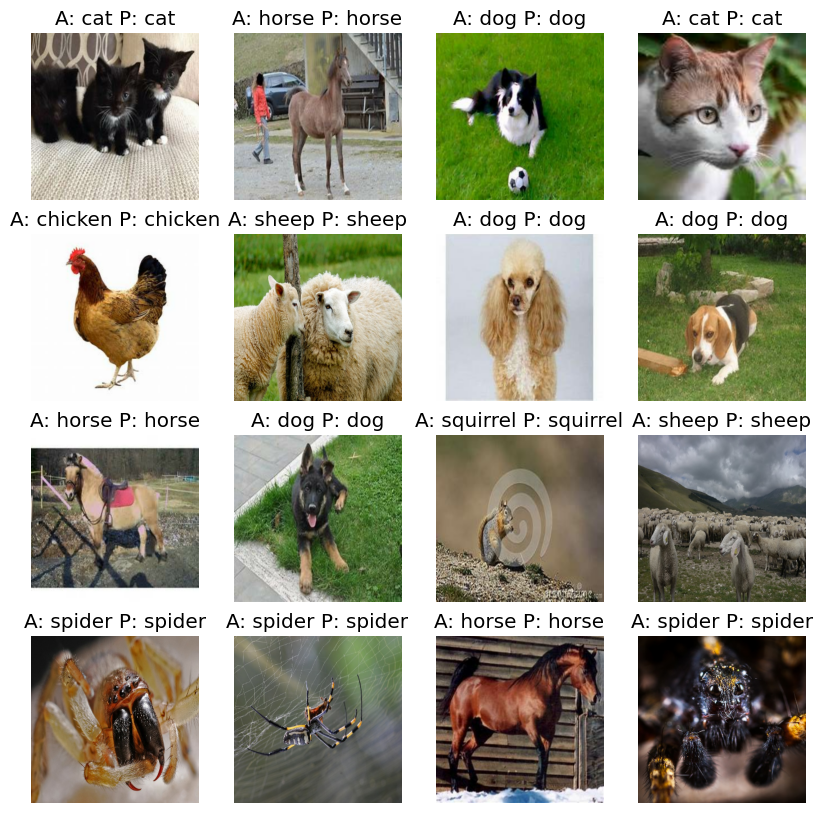

In [ ]:
# Visualización de predicciones con etiquetas

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    y_true =  np.argmax(labels,axis=1)
    prediction = inception_model.predict(images)
    y_pred = np.argmax(prediction,axis=1)
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(f'A: {class_names[y_true[i]]} P: {classes[y_pred[i]]}')
        plt.axis("off")

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
En el ejemplo que hemos seleccionado la predicción de las clases de las 16 imágenes se ha llevado a cabo de forma correcta. Dependiendo de la ejecución puede aparecer un ejemplo erróneo, pero se da en muy pocas ocasiones.
<br><br>
</div>

## 7. Mejora de resultados (1 punto)

En este último apartado se deja libertad al alumno para conseguir, mediante el diseño de una red propia, unos mejores resultados en la tarea de clasificación.

Se valorarará la justificación de las elecciones realizadas.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio[1 punto]:</strong> Implementar un modelo para llevar a cabo la tarea de clasificación:
    <ul>
        <li>Diseñar la arquitectura de la red</li>
        <li>Compilar el modelo</li>
        <li>Llevar a cabo el entrenamientio</li>
        <li>Evaluar el modelo presentando las métricas y gráficas adecuadas</li>
        <li>Comentar los resultados obtenidos</li>
    </ul>
</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
(Añade tus comentarios substituyendo este texto)
<br><br>
</div>